# Performance Evaluation
Kevin Ta 2021.04.04

In [1]:
# Import relevant modules
import os
import time
from datetime import datetime
from scipy import signal

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import joblib
import pickle as pkl

In [2]:
# define parameters for retrieving files
WIN_SIZE = 32
INTENTIONS_DICT = [
    ('Mahsa', 'StraightF', 'T2'),
    ('Mahsa', 'Turn90FL', 'T2'),
    ('Mahsa', 'Turn90FR', 'T1'),
    ]
INTENTIONS_DICT2 = [
    ('Mahsa', 'Obstacles15', 'T1'),
    ('Mahsa', 'Obstacles35', 'T3'),
    ('Mahsa', 'RampA', 'T1'),
    ('Mahsa', 'StraightF', 'T2'),
    ('Mahsa', 'Turn90FL', 'T2'),
    ('Mahsa', 'Turn90FR', 'T1'),
    ('Mahsa', 'Turn180L', 'T2'),
    ('Mahsa', 'Turn180R', 'T2'),
]

# set the current directory
current_path = os.getcwd()

# map clusters for colours
cluster_dict = {'Cluster 1': 0, 'Cluster 2':1, 'Cluster 3':2, 'Cluster 4':3, 'Cluster 5':4, 'Cluster 6':5}

In [3]:
def fPlot(timeVal, torqueL, torqueR, cols, name):
    
    # plot
    fig, ax1 = plt.subplots(figsize=(16,3.5))

    # plot torques with appropriate colour mapping
    ax1.scatter(np.arange(len(torqueL)), torqueL, marker = 'o', facecolor = 'w', color=cols)
    ax1.scatter(np.arange(len(torqueR)), torqueR, marker = '^', facecolor = 'w', color=cols)

    #ax1.set_xlim((timeVal.min(), timeVal.max()))

    # legend
    ax1.legend(['Torque (L)', 'Torque (R)'])

    ax1.set_title(name)
    
    plt.grid(which='both')

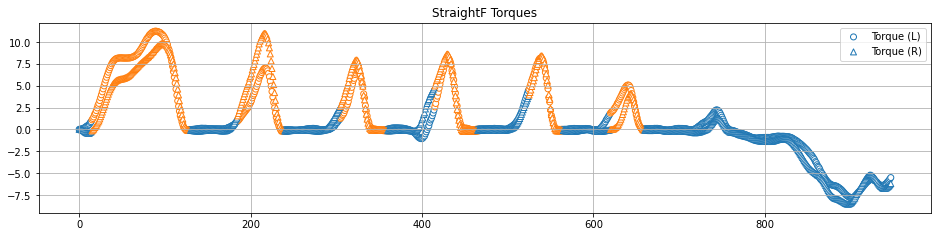

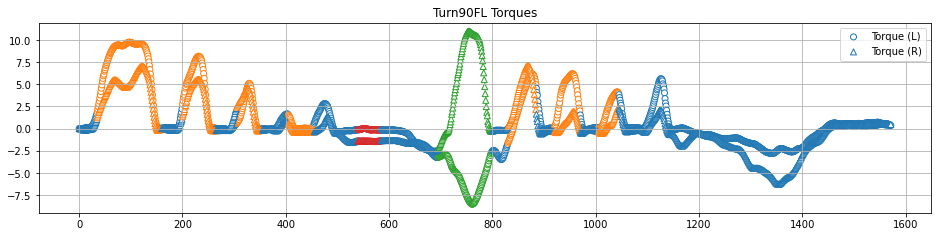

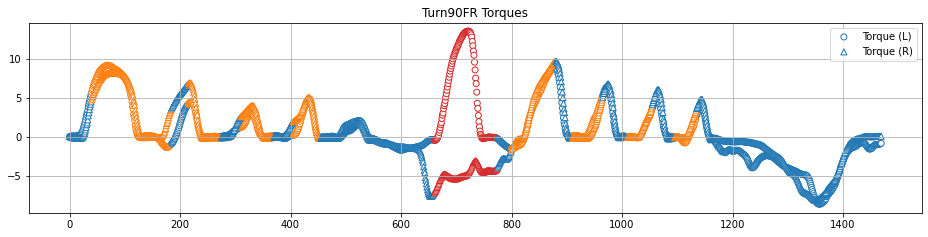

In [4]:
col = sns.color_palette('tab10')

model = 'RF'

cols ={}

data = pd.read_csv(os.path.join(current_path, '2021-Results',model, '240Hz-{}-{}-{}.csv'.format(WIN_SIZE, INTENTIONS_DICT[0][1], INTENTIONS_DICT[0][0])))

straightGT = np.zeros((len(data),4))
straightGT[0:15, 0] = 1
straightGT[15:130, 1] = 1
straightGT[130:185, 0] = 1
straightGT[185:240, 1] = 1
straightGT[240:305, 0] = 1
straightGT[305:360, 1] = 1
straightGT[360:415, 0] = 1
straightGT[415:465, 1] = 1
straightGT[465:525, 0] = 1
straightGT[525:565, 1] = 1
straightGT[565:620, 0] = 1
straightGT[620:660, 1] = 1
straightGT[660::, 0] = 1

cols[0] = [col[i] for i in straightGT.argmax(axis=1)]

data = pd.read_csv(os.path.join(current_path, '2021-Results',model, '240Hz-{}-{}-{}.csv'.format(WIN_SIZE, INTENTIONS_DICT[1][1], INTENTIONS_DICT[1][0])))

leftGT = np.zeros((len(data),4))
leftGT[0:35, 0] = 1
leftGT[35:160, 1] = 1
leftGT[160:200, 0] = 1
leftGT[200:265, 1] = 1
leftGT[265:305, 0] = 1
leftGT[305:355, 1] = 1
leftGT[355:405, 0] = 1
leftGT[405:455, 1] = 1
leftGT[455:540, 0] = 1
leftGT[540:585, 3] = 1
leftGT[585:695, 0] = 1
leftGT[695:800, 2] = 1
leftGT[800:830, 0] = 1
leftGT[830:885, 1] = 1
leftGT[885:920, 0] = 1
leftGT[920:970, 1] = 1
leftGT[970:1005, 0] = 1
leftGT[1005:1045, 1] = 1
leftGT[1045:1620, 0] = 1
leftGT[1620::, 1] = 1

cols[1] = [col[i] for i in leftGT.argmax(axis=1)]

data = pd.read_csv(os.path.join(current_path, '2021-Results',model, '240Hz-{}-{}-{}.csv'.format(WIN_SIZE, INTENTIONS_DICT[2][1], INTENTIONS_DICT[2][0])))

rightGT = np.zeros((len(data),4))
rightGT[0:40, 0] = 1
rightGT[40:185, 1] = 1
rightGT[185:215, 0] = 1
rightGT[215:275, 1] = 1
rightGT[275:310, 0] = 1
rightGT[310:370, 1] = 1
rightGT[370:405, 0] = 1
rightGT[405:455, 1] = 1
rightGT[455:660, 0] = 1
rightGT[660:775, 3] = 1
rightGT[775:800, 0] = 1
rightGT[800:880, 1] = 1
rightGT[880:910, 0] = 1
rightGT[910:965, 1] = 1
rightGT[965:1010, 0] = 1
rightGT[1010:1055, 1] = 1
rightGT[1055:1095, 0] = 1
rightGT[1095:1135, 1] = 1
rightGT[1135::, 0] = 1

cols[2] = [col[i] for i in rightGT.argmax(axis=1)]

for i, item in enumerate(INTENTIONS_DICT):
    
    data = pd.read_csv(os.path.join(current_path, '2021-Results',model, '240Hz-{}-{}-{}.csv'.format(WIN_SIZE, item[1], item[0])))

    # extract cluster probabilities and torque values
    clusters = data[['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6']]
    torques = data[['Torque L', 'Torque R']]
    
    cluster_4 = np.array([clusters['Cluster 1'] + clusters['Cluster 4'] + clusters['Cluster 5'], clusters['Cluster 3'], 
                          clusters['Cluster 6'], clusters['Cluster 2']])
    
    fPlot(data['Time'], data['Torque L'], data['Torque R'], cols[i], '{} Torques'.format(item[1]))

In [5]:
def fBayesianTrack(clusters, process_model):

    # prior update and measurement update arrays
    p_xc_zp = np.ones(4)/4
    p_xc_zc = np.ones(4)/4

    # filtered clusters
    probBT = np.array([p_xc_zc])

    # perform updates
    for cluster_model in clusters.T:
        p_xc_zp = process_model @ p_xc_zc
        p_xc_zc =  np.multiply(cluster_model, p_xc_zp) / (cluster_model @ p_xc_zp) 
        probBT = np.append(probBT, p_xc_zc.reshape(1,-1), axis=0)

    # remove initial uniform result
    return probBT[1::]

In [6]:
process_model = joblib.load('HMP.joblib')

straightGT = np.zeros((len(data),4))
straightGT[0:25, 0] = 1
straightGT[5:140, 1] = 1
straightGT[120:195, 0] = 1
straightGT[175:250, 1] = 1
straightGT[230:315, 0] = 1
straightGT[295:370, 1] = 1
straightGT[350:425, 0] = 1
straightGT[405:475, 1] = 1
straightGT[455:535, 0] = 1
straightGT[515:575, 1] = 1
straightGT[555:630, 0] = 1
straightGT[610:670, 1] = 1
straightGT[650::, 0] = 1

data = pd.read_csv(os.path.join(current_path, '2021-Results', model, '240Hz-{}-{}-{}.csv'.format(WIN_SIZE, INTENTIONS_DICT[1][1], INTENTIONS_DICT[1][0])))

leftGT = np.zeros((len(data),4))
leftGT[0:45, 0] = 1
leftGT[25:170, 1] = 1
leftGT[150:210, 0] = 1
leftGT[190:275, 1] = 1
leftGT[255:315, 0] = 1
leftGT[295:365, 1] = 1
leftGT[345:415, 0] = 1
leftGT[395:465, 1] = 1
leftGT[445:550, 0] = 1
leftGT[530:595, 3] = 1
leftGT[575:705, 0] = 1
leftGT[685:810, 2] = 1
leftGT[790:840, 0] = 1
leftGT[820:895, 1] = 1
leftGT[875:930, 0] = 1
leftGT[910:980, 1] = 1
leftGT[960:1015, 0] = 1
leftGT[995:1055, 1] = 1
leftGT[1035:1630, 0] = 1
leftGT[1610::, 1] = 1

data = pd.read_csv(os.path.join(current_path, '2021-Results', model, '240Hz-{}-{}-{}.csv'.format(WIN_SIZE, INTENTIONS_DICT[2][1], INTENTIONS_DICT[2][0])))

rightGT = np.zeros((len(data),4))
rightGT[0:50, 0] = 1
rightGT[30:195, 1] = 1
rightGT[175:225, 0] = 1
rightGT[205:285, 1] = 1
rightGT[265:320, 0] = 1
rightGT[300:380, 1] = 1
rightGT[360:415, 0] = 1
rightGT[395:465, 1] = 1
rightGT[445:670, 0] = 1
rightGT[650:785, 3] = 1
rightGT[765:810, 0] = 1
rightGT[790:890, 1] = 1
rightGT[870:920, 0] = 1
rightGT[900:975, 1] = 1
rightGT[955:1020, 0] = 1
rightGT[1000:1065, 1] = 1
rightGT[1045:1105, 0] = 1
rightGT[1085:1135, 1] = 1
rightGT[1125::, 0] = 1

GT = [straightGT, leftGT, rightGT]

In [7]:
repeatThreshold = 15

pred_RF_total = []
pred_RF_BT_total = []

for i, item in enumerate(INTENTIONS_DICT):
    
    data = pd.read_csv(os.path.join(current_path, '2021-Results',model, '240Hz-{}-{}-{}.csv'.format(WIN_SIZE, item[1], item[0])))
    
    # extract cluster probabilities and torque values
    clusters = data[['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6']]
    torques = data[['Torque L', 'Torque R']]
    
    cluster_4 = np.array([clusters['Cluster 1'] + clusters['Cluster 4'] + clusters['Cluster 5'], clusters['Cluster 3'], 
                          clusters['Cluster 6'], clusters['Cluster 2']])
    
    probBT = fBayesianTrack(cluster_4, process_model)
    
    # get cluster index
    cluster_pred_RF = cluster_4.argmax(axis=0)
    cluster_pred_RF_BT = probBT.T.argmax(axis=0)
    
    pred_RF = []
    pred_RF_BT = []
    
    for j, idx in enumerate(cluster_pred_RF_BT):
    
        if GT[i][j, idx] == 1:
            pred_RF_BT.append(1)
            pred_RF_BT_total.append(1)
        else:
            pred_RF_BT.append(0)
            pred_RF_BT_total.append(0)
    
    for j, idx in enumerate(cluster_pred_RF):
    
        if GT[i][j, idx] == 1:
            pred_RF.append(1)
            pred_RF_total.append(1)
        else:
            pred_RF.append(0)
            pred_RF_total.append(0)
    
    print(item)
    
    print('Accuracy for RF')
    print('RF:    {}'.format(np.array(pred_RF).mean()))
    print('RF-BT: {}'.format(np.array(pred_RF_BT).mean()))
    
    print('Sequences less than {}'.format(repeatThreshold))
    repeat_RF = np.array([len(list(y)) for x, y in itertools.groupby(cluster_pred_RF)])
    print('RF:    {}'.format(np.sum(repeat_RF <= repeatThreshold)))
    repeat_RF_BT = np.array([len(list(y)) for x, y in itertools.groupby(cluster_pred_RF_BT)])
    print('RF-BT: {}'.format(np.sum(repeat_RF_BT <= repeatThreshold)))

print('Total Accuracy for RF')
print('RF:    {}'.format(np.array(pred_RF_total).mean()))
print('RF-BT: {}'.format(np.array(pred_RF_BT_total).mean())) 

('Mahsa', 'StraightF', 'T2')
Accuracy for RF
RF:    0.8217299578059072
RF-BT: 0.830168776371308
Sequences less than 15
RF:    9
RF-BT: 5
('Mahsa', 'Turn90FL', 'T2')
Accuracy for RF
RF:    0.8136132315521628
RF-BT: 0.8346055979643766
Sequences less than 15
RF:    28
RF-BT: 11
('Mahsa', 'Turn90FR', 'T1')
Accuracy for RF
RF:    0.7687074829931972
RF-BT: 0.7693877551020408
Sequences less than 15
RF:    13
RF-BT: 6
Total Accuracy for RF
RF:    0.7989974937343358
RF-BT: 0.8095238095238095


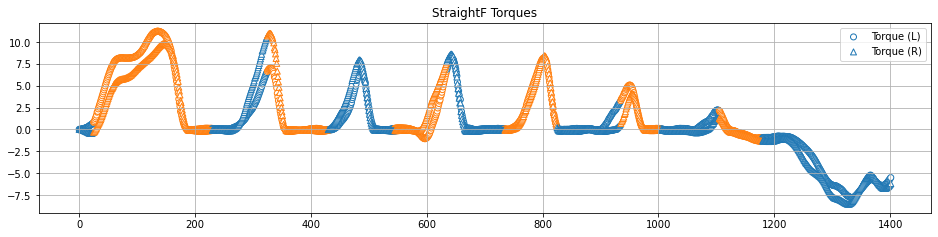

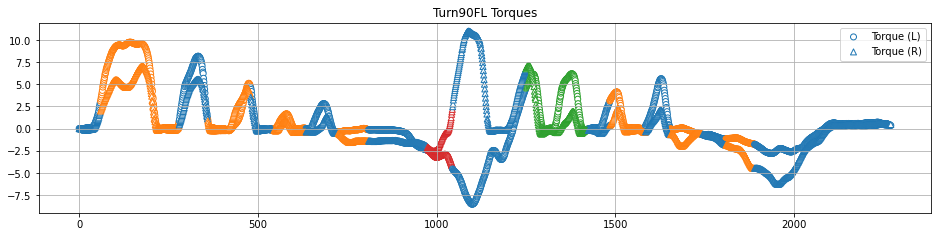

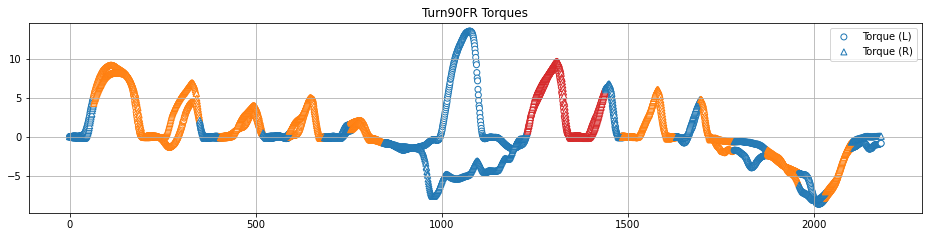

In [8]:
col = sns.color_palette('tab10')

model = 'GMM'

cols ={}

data = pd.read_csv(os.path.join(current_path, '2021-Results',model, '240Hz-{}-{}-{}.csv'.format(WIN_SIZE, INTENTIONS_DICT[0][1], INTENTIONS_DICT[0][0])))

straightGT = np.zeros((len(data),4))
straightGT[0:25, 0] = 1
straightGT[25:230, 1] = 1
straightGT[230:325, 0] = 1
straightGT[325:430, 1] = 1
straightGT[430:545, 0] = 1
straightGT[545:635, 1] = 1
straightGT[635:735, 0] = 1
straightGT[735:825, 1] = 1
straightGT[825:935, 0] = 1
straightGT[935:1005, 1] = 1
straightGT[1005:1105, 0] = 1
straightGT[1105:1180, 1] = 1
straightGT[1180::, 0] = 1

cols[0] = [col[i] for i in straightGT.argmax(axis=1)]

data = pd.read_csv(os.path.join(current_path, '2021-Results',model, '240Hz-{}-{}-{}.csv'.format(WIN_SIZE, INTENTIONS_DICT[1][1], INTENTIONS_DICT[1][0])))

leftGT = np.zeros((len(data),4))
leftGT[0:60, 0] = 1
leftGT[60:280, 1] = 1
leftGT[280:360, 0] = 1
leftGT[360:480, 1] = 1
leftGT[480:545, 0] = 1
leftGT[545:635, 1] = 1
leftGT[635:725, 0] = 1
leftGT[725:810, 1] = 1
leftGT[810:975, 0] = 1
leftGT[975:1045, 3] = 1
leftGT[1045:1250, 0] = 1
leftGT[1250:1425, 2] = 1
leftGT[1425:1485, 0] = 1
leftGT[1485:1585, 1] = 1
leftGT[1585:1655, 0] = 1
leftGT[1655:1745, 1] = 1
leftGT[1745:1810, 0] = 1
leftGT[1810:1890, 1] = 1
leftGT[1890:2950, 0] = 1
leftGT[2950::, 1] = 1

cols[1] = [col[i] for i in leftGT.argmax(axis=1)]

data = pd.read_csv(os.path.join(current_path, '2021-Results',model, '240Hz-{}-{}-{}.csv'.format(WIN_SIZE, INTENTIONS_DICT[2][1], INTENTIONS_DICT[2][0])))

rightGT = np.zeros((len(data),4))
rightGT[0:65, 0] = 1
rightGT[65:350, 1] = 1
rightGT[350:405, 0] = 1
rightGT[405:520, 1] = 1
rightGT[520:590, 0] = 1
rightGT[590:685, 1] = 1
rightGT[685:755, 0] = 1
rightGT[755:845, 1] = 1
rightGT[845:1230, 0] = 1
rightGT[1230:1440, 3] = 1
rightGT[1440:1485, 0] = 1
rightGT[1485:1630, 1] = 1
rightGT[1630:1695, 0] = 1
rightGT[1695:1785, 1] = 1
rightGT[1785:1875, 0] = 1
rightGT[1875:1960, 1] = 1
rightGT[1960:2030, 0] = 1
rightGT[2030:2100, 1] = 1
rightGT[2100::, 0] = 1

cols[2] = [col[i] for i in rightGT.argmax(axis=1)]

for i, item in enumerate(INTENTIONS_DICT):
    
    data = pd.read_csv(os.path.join(current_path, '2021-Results',model, '240Hz-{}-{}-{}.csv'.format(WIN_SIZE, item[1], item[0])))

    # extract cluster probabilities and torque values
    clusters = data[['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6']]
    torques = data[['Torque L', 'Torque R']]
    
    cluster_4 = np.array([clusters['Cluster 1'] + clusters['Cluster 4'] + clusters['Cluster 5'], clusters['Cluster 3'], 
                          clusters['Cluster 6'], clusters['Cluster 2']])
    
    fPlot(data['Time'], data['Torque L'], data['Torque R'], cols[i], '{} Torques'.format(item[1]))

In [9]:
data = pd.read_csv(os.path.join(current_path, '2021-Results',model, '240Hz-{}-{}-{}.csv'.format(WIN_SIZE, INTENTIONS_DICT[0][1], INTENTIONS_DICT[0][0])))

straightGT = np.zeros((len(data),4))
straightGT[0:40, 0] = 1
straightGT[10:245, 1] = 1
straightGT[215:340, 0] = 1
straightGT[310:445, 1] = 1
straightGT[415:560, 0] = 1
straightGT[530:650, 1] = 1
straightGT[620:750, 0] = 1
straightGT[720:840, 1] = 1
straightGT[810:950, 0] = 1
straightGT[920:1020, 1] = 1
straightGT[990:1120, 0] = 1
straightGT[1090:1195, 1] = 1
straightGT[1165::, 0] = 1

data = pd.read_csv(os.path.join(current_path, '2021-Results',model, '240Hz-{}-{}-{}.csv'.format(WIN_SIZE, INTENTIONS_DICT[1][1], INTENTIONS_DICT[1][0])))

leftGT = np.zeros((len(data),4))
leftGT[0:75, 0] = 1
leftGT[45:295, 1] = 1
leftGT[265:375, 0] = 1
leftGT[345:495, 1] = 1
leftGT[465:560, 0] = 1
leftGT[530:650, 1] = 1
leftGT[620:740, 0] = 1
leftGT[710:825, 1] = 1
leftGT[795:990, 0] = 1
leftGT[960:1060, 3] = 1
leftGT[1030:1275, 0] = 1
leftGT[1235:1440, 2] = 1
leftGT[1410:1500, 0] = 1
leftGT[1470:1600, 1] = 1
leftGT[1570:1670, 0] = 1
leftGT[1640:1760, 1] = 1
leftGT[1730:1825, 0] = 1
leftGT[1795:1905, 1] = 1
leftGT[1875:2965, 0] = 1
leftGT[2935::, 1] = 1

data = pd.read_csv(os.path.join(current_path, '2021-Results',model, '240Hz-{}-{}-{}.csv'.format(WIN_SIZE, INTENTIONS_DICT[2][1], INTENTIONS_DICT[2][0])))

rightGT = np.zeros((len(data),4))
rightGT[0:80, 0] = 1
rightGT[50:365, 1] = 1
rightGT[335:420, 0] = 1
rightGT[390:535, 1] = 1
rightGT[505:605, 0] = 1
rightGT[575:700, 1] = 1
rightGT[670:770, 0] = 1
rightGT[740:860, 1] = 1
rightGT[830:1245, 0] = 1
rightGT[1215:1455, 3] = 1
rightGT[1425:1500, 0] = 1
rightGT[1470:1645, 1] = 1
rightGT[1615:1710, 0] = 1
rightGT[1680:1800, 1] = 1
rightGT[1770:1890, 0] = 1
rightGT[1860:1975, 1] = 1
rightGT[1945:2045, 0] = 1
rightGT[2015:2115, 1] = 1
rightGT[2085::, 0] = 1

GT = [straightGT, leftGT, rightGT]

In [10]:
repeatThreshold = 30

pred_GMM_total = []
pred_GMM_BT_total = []

for i, item in enumerate(INTENTIONS_DICT):
    
    data = pd.read_csv(os.path.join(current_path, '2021-Results',model, '240Hz-{}-{}-{}.csv'.format(WIN_SIZE, item[1], item[0])))
    
    # extract cluster probabilities and torque values
    clusters = data[['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6']]
    torques = data[['Torque L', 'Torque R']]
    
    cluster_4 = np.array([clusters['Cluster 1'] + clusters['Cluster 4'] + clusters['Cluster 5'], clusters['Cluster 3'], 
                          clusters['Cluster 6'], clusters['Cluster 2']])
    
    probBT = fBayesianTrack(cluster_4, process_model)
    
    # get cluster index
    cluster_pred_GMM = cluster_4.argmax(axis=0)
    cluster_pred_GMM_BT = probBT.T.argmax(axis=0)
    
    pred_GMM = []
    pred_GMM_BT = []
    
    for j, idx in enumerate(cluster_pred_GMM_BT):
    
        if GT[i][j, idx] == 1:
            pred_GMM_BT.append(1)
            pred_GMM_BT_total.append(1)
        else:
            pred_GMM_BT.append(0)
            pred_GMM_BT_total.append(0)
    
    for j, idx in enumerate(cluster_pred_GMM):
    
        if GT[i][j, idx] == 1:
            pred_GMM.append(1)
            pred_GMM_total.append(1)
        else:
            pred_GMM.append(0)
            pred_GMM_total.append(0)
    
    print(item)
    
    print('Accuracy for GMM')
    print('GMM:    {}'.format(np.array(pred_GMM).mean()))
    print('GMM-BT: {}'.format(np.array(pred_GMM_BT).mean()))
    
    print('Sequences less than {}'.format(repeatThreshold))
    repeat_GMM = np.array([len(list(y)) for x, y in itertools.groupby(cluster_pred_GMM)])
    print('GMM:    {}'.format(np.sum(repeat_GMM <= repeatThreshold)))
    repeat_GMM_BT = np.array([len(list(y)) for x, y in itertools.groupby(cluster_pred_GMM_BT)])
    print('GMM-BT: {}'.format(np.sum(repeat_GMM_BT <= repeatThreshold)))

print('Total Accuracy for RF')
print('GMM:    {}'.format(np.array(pred_GMM_total).mean()))
print('GMM-BT: {}'.format(np.array(pred_GMM_BT_total).mean())) 

('Mahsa', 'StraightF', 'T2')
Accuracy for GMM
GMM:    0.7089871611982882
GMM-BT: 0.7097004279600571
Sequences less than 30
GMM:    15
GMM-BT: 11
('Mahsa', 'Turn90FL', 'T2')
Accuracy for GMM
GMM:    0.5941901408450704
GMM-BT: 0.5941901408450704
Sequences less than 30
GMM:    20
GMM-BT: 20
('Mahsa', 'Turn90FR', 'T1')
Accuracy for GMM
GMM:    0.6143970655662541
GMM-BT: 0.6189821182943603
Sequences less than 30
GMM:    25
GMM-BT: 17
Total Accuracy for RF
GMM:    0.6292058070025619
GMM-BT: 0.6310845431255337


In [13]:
repeatThresholdGMM = 12
repeatThresholdRF = 8

pred_RF_total = []
pred_GMM_BT_total = []
pred_GMM_total = []
pred_GMM_BT_total = []

for i, item in enumerate(INTENTIONS_DICT2):
    
    data = pd.read_csv(os.path.join(current_path, '2021-Results', 'GMM', '240Hz-{}-{}-{}.csv'.format(WIN_SIZE, item[1], item[0])))
    
    # extract cluster probabilities and torque values
    clusters = data[['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6']]
    torques = data[['Torque L', 'Torque R']]
    
    cluster_4 = np.array([clusters['Cluster 1'] + clusters['Cluster 4'] + clusters['Cluster 5'], clusters['Cluster 3'], 
                          clusters['Cluster 6'], clusters['Cluster 2']])
    
    probBT = fBayesianTrack(cluster_4, process_model)
    
    # get cluster index
    cluster_pred_GMM = cluster_4.argmax(axis=0)
    cluster_pred_GMM_BT = probBT.T.argmax(axis=0)
    
    data = pd.read_csv(os.path.join(current_path, '2021-Results', 'RF', '240Hz-{}-{}-{}.csv'.format(WIN_SIZE, item[1], item[0])))
    
    # extract cluster probabilities and torque values
    clusters = data[['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6']]
    torques = data[['Torque L', 'Torque R']]
    
    cluster_4 = np.array([clusters['Cluster 1'] + clusters['Cluster 4'] + clusters['Cluster 5'], clusters['Cluster 3'], 
                          clusters['Cluster 6'], clusters['Cluster 2']])
    
    probBT = fBayesianTrack(cluster_4, process_model)
    
    # get cluster index
    cluster_pred_RF = cluster_4.argmax(axis=0)
    cluster_pred_RF_BT = probBT.T.argmax(axis=0)
    
    print(item)
    
    print('Sequences less than {}'.format(repeatThresholdGMM))
    repeat_GMM = np.array([len(list(y)) for x, y in itertools.groupby(cluster_pred_GMM)])
    print('GMM:    {}'.format(np.sum(repeat_GMM <= repeatThresholdGMM)))
    repeat_GMM_BT = np.array([len(list(y)) for x, y in itertools.groupby(cluster_pred_GMM_BT)])
    print('GMM-BT: {}'.format(np.sum(repeat_GMM_BT <= repeatThresholdGMM)))
    print('Sequences less than {}'.format(repeatThresholdRF))
    repeat_RF = np.array([len(list(y)) for x, y in itertools.groupby(cluster_pred_RF)])
    print('RF:     {}'.format(np.sum(repeat_RF <= repeatThresholdRF)))
    repeat_RF_BT = np.array([len(list(y)) for x, y in itertools.groupby(cluster_pred_RF_BT)])
    print('RF-BT:  {}'.format(np.sum(repeat_RF_BT <= repeatThresholdRF)))

('Mahsa', 'Obstacles15', 'T1')
Sequences less than 12
GMM:    7
GMM-BT: 6
Sequences less than 8
RF:     8
RF-BT:  3
('Mahsa', 'Obstacles35', 'T3')
Sequences less than 12
GMM:    5
GMM-BT: 3
Sequences less than 8
RF:     3
RF-BT:  2
('Mahsa', 'RampA', 'T1')
Sequences less than 12
GMM:    36
GMM-BT: 27
Sequences less than 8
RF:     17
RF-BT:  5
('Mahsa', 'StraightF', 'T2')
Sequences less than 12
GMM:    9
GMM-BT: 5
Sequences less than 8
RF:     5
RF-BT:  2
('Mahsa', 'Turn90FL', 'T2')
Sequences less than 12
GMM:    9
GMM-BT: 9
Sequences less than 8
RF:     20
RF-BT:  6
('Mahsa', 'Turn90FR', 'T1')
Sequences less than 12
GMM:    20
GMM-BT: 14
Sequences less than 8
RF:     11
RF-BT:  5
('Mahsa', 'Turn180L', 'T2')
Sequences less than 12
GMM:    8
GMM-BT: 5
Sequences less than 8
RF:     2
RF-BT:  0
('Mahsa', 'Turn180R', 'T2')
Sequences less than 12
GMM:    9
GMM-BT: 7
Sequences less than 8
RF:     7
RF-BT:  2
